In [1]:
import torch
import numpy as np
import pandas as pd
import wfdb
from datetime import datetime, timedelta

In [1]:
class CardiacExample:
    def __init__(self, input_, answer, llm_answer, llm_explanation):
        self.input = input_
        self.answer = answer
        self.llm_answer = llm_answer 
        self.llm_explanation = llm_explanation
        self.claims = []
        self.relevant_claims = []
        self.alignment_scores = []
        self.expert_criteria = []
        self.alignment_reasonings = []

In [ ]:
cardiac_examples = []
for idx,row in tqdm(cardiac_data.iterrows()):
    llm_answer, explanation = get_llm_generated_answer(row['text'])
    if llm_answer is None:
        continue
    cardiac_examples.append(CardiacExample(
        input_, answer, llm_answer, llm_explanation
    ))

In [2]:
# work done in hylian machine

waveform_summary = pd.read_csv("/tmp/mc-med-1.0.0/data/waveform_summary.csv")
waveform_summary = waveform_summary[waveform_summary['Type'] == 'II']
waveform_summary.head()

,CSN,Type,Segments,Duration
0,99633476,II,1,2204.742
4,99960476,II,4,12818.304
7,99470476,II,2,13918.498
11,99438476,II,2,11579.046
15,99439476,II,3,2853.788


In [3]:
waveform_summary['CSN']

0         99633476
4         99960476
7         99470476
11        99438476
15        99439476
            ...   
188298    99413106
188306    99876106
188307    99539106
188310    99647106
188314    99289106
Name: CSN, Length: 55160, dtype: int64

In [4]:
Full_CSN = 99016000 # as an example 

In [5]:
waveform_summary[waveform_summary['CSN'] == Full_CSN]

,CSN,Type,Segments,Duration
58946,99016000,II,2,1166.926


## Waveform Data -- we use ECG
The data are organized into compressed archives (waveforms_0xx.zip, waveforms_1xx.zip, etc.) based on the last three digits of each Visit ID (CSN). Each ZIP archive extracts to a nested folder structure:

```
    {CSN_suffix}/              # Folder named by last three digits of the CSN
        {Full_CSN}/            # Folder named by the full CSN (visit identifier)
            II/                # ECG waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
            Pleth/             # PPG waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
                ...
            Resp/              # Respiration waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
```

### Some pre-processing

In [6]:
########################
# FYI - 
# the following has no alarms
# CSN_suffix = '000' 
# CSN_suffix = '001' 
# CSN_suffix = '002' 


In [7]:
CSN_suffix = '003'
waveform_type = 'II'
records_path = f"/tmp/mc-med-1.0.0/data/waveforms/{CSN_suffix}/RECORDS"

with open(records_path, "r") as f:
    lines = f.read().split('\n')

segment_paths = [line for line in lines if waveform_type in line]
# segment_paths

In [8]:
patient_ids = torch.tensor([int(segment_path[:8]) for segment_path in segment_paths]).unique()
print(patient_ids.shape)
patient_ids

torch.Size([53])


tensor([98974003, 98976003, 98982003, 98987003, 98989003, 98996003, 99011003,
        99021003, 99068003, 99070003, 99120003, 99146003, 99147003, 99200003,
        99266003, 99271003, 99298003, 99320003, 99335003, 99336003, 99390003,
        99396003, 99407003, 99430003, 99445003, 99485003, 99508003, 99530003,
        99554003, 99588003, 99596003, 99609003, 99618003, 99649003, 99654003,
        99655003, 99659003, 99672003, 99674003, 99679003, 99696003, 99747003,
        99759003, 99824003, 99831003, 99877003, 99881003, 99915003, 99916003,
        99937003, 99965003, 99973003, 99996003])

#### Import alarm data
and check if any of our patients had a cardiac arrest alarm


In [9]:
alarms_df = pd.read_parquet('../data/sick_time.parquet', engine='pyarrow')

alarm_patient_ids = torch.tensor([i.item() for i in patient_ids if i in alarms_df['CSN'].unique()])
alarm_patient_ids

tensor([99996003])

In [97]:
alarms_df

,CSN,Alarm
0,98974916,2288-12-08 10:17:39
1,98975250,2279-10-24 08:40:37
2,98982225,2238-07-19 10:31:15
3,98990360,2242-01-14 19:43:37
4,98995384,2276-05-18 10:59:45
...,...,...
438,99994144,2228-04-08 15:13:19
439,99995451,2273-04-24 12:04:55
440,99996003,2225-03-31 12:08:57
442,99997362,2205-12-12 16:44:12


#### Create some dicts for easy use

In [10]:
patients_segments_dict = {}

for patient_id in patient_ids:
    patients_segments_dict[patient_id.item()] = [segment_path for segment_path in segment_paths if int(segment_path[:8]) == patient_id.item()]

# patients_segments_dict

In [11]:
patients_records_dict = {}

for patient_id in patients_segments_dict:
    record_list = []
    for segment_path in patients_segments_dict[patient_id]:
        data_path = f"/tmp/mc-med-1.0.0/data/waveforms/{CSN_suffix}/{segment_path}"
        # Read the record
        record = wfdb.rdrecord(data_path)
        record_list.append(record)
    patients_records_dict[patient_id] = record_list

# patients_records_dict

### Ok, we are ready to go!

In [47]:
if alarm_patient_ids.numel() == 0:
    print("No alarm!")
    Full_CSN = patient_ids[0].item() # Full_CSN is another name for patient_id
else:
    print("Yes alarm!")
    Full_CSN = alarm_patient_ids[0].item()
print('Patient id:', Full_CSN)
patients_records_dict[Full_CSN]

Yes alarm!
Patient id: 99996003


In [82]:
records = patients_records_dict[Full_CSN]

In [83]:
record1 = records[0]
print(record1.__dict__)

{'record_name': '99996003_1', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 476497, 'base_time': datetime.time(12, 0, 13, 772000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.024923  ],
       [-0.0199384 ],
       [-0.0099692 ],
       ...,
       [ 0.0348922 ],
       [ 0.23427618],
       [ 0.33396817]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_1.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [401.23583934088566], 'baseline': [-99], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [-109], 'checksum': [17044], 'block_size': [0]}


In [78]:
def get_start_end_times(record):
    start_dt = datetime.combine(datetime.today(), record.base_time)
    duration_sec = record.sig_len / record.fs
    end_dt = start_dt + timedelta(seconds=duration_sec)
    print("Date:", record.base_date)
    print("Start time:", record.base_time)
    print("End time:", end_dt.time())
    return
    # return start_dt, end_dt

get_start_end_times(record1)

Date: 2225-03-31
Start time: 12:00:13.772000
End time: 12:16:06.766000


In [121]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]

Timestamp('2225-03-31 12:08:57')

In [124]:
ts = alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]
dt = datetime(2225, 3, 31, 12, 8, 57)

print(ts == dt)   # True
print(ts < dt) 

True
False


In [116]:
current_time.time()

datetime.time(12, 16, 6, 764000)

In [119]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].to_numpy()[0] == current_time.time()

False

In [349]:
from datetime import datetime, timedelta

def get_measurements(record, alarm_ts=None, cutoff_minutes=1, new_fs=40):
    """
    new_fs: the downsampled number of samples taken per second (i.e. Hz)
    """
    signal = record.p_signal[:, 0]  # 1D array of measurements 
    start_time = datetime.combine(record.base_date, record.base_time)

    formatted = []

    # Determine cutoff time in seconds since start
    if alarm_ts is None:
        end_time = start_time + timedelta(seconds=record.sig_len / record.fs)
        cutoff_time = end_time - timedelta(minutes=cutoff_minutes)
    else:
        cutoff_time = alarm_ts - timedelta(minutes=cutoff_minutes)
    total_duration = (cutoff_time - start_time).total_seconds()
    max_idx = min(len(signal), int(total_duration * record.fs))

    step_sz = int(record.fs // new_fs)

    for i in range(0, max_idx, step_sz):
        current_time = start_time + timedelta(seconds=i / record.fs)
        # formatted.append(f"{current_time.time()}, {signal[i]:.6f}")
        formatted.append(signal[i])
    return np.array(formatted), start_time, cutoff_time, new_fs


In [350]:
measurements, start_time, cutoff_time, new_fs = get_measurements(record1, alarm_ts)
print(measurements[:5])
print(len(measurements))
print("Sanity check for last entry: ", measurements[-1])

[-0.024923    0.          0.12461499 -0.40624487 -0.24922998]
19302
Sanity check for last entry:  -0.05981519507186859


In [344]:
measurements, start_time, cutoff_time, new_fs = get_measurements(record1)
print(measurements[:5])
print(len(measurements))
print("Sanity check for last entry: ", measurements[-1])

[-0.024923   -0.0199384   0.61559805 -0.75516684 -0.30406057]
44650
Sanity check for last entry:  -0.22929158110882958


In [223]:
measurements.shape

(446498,)

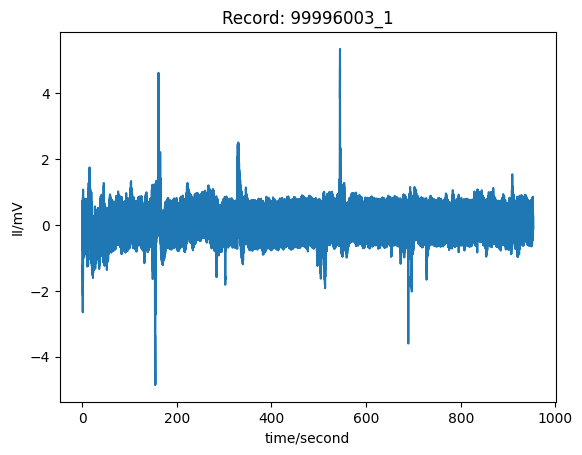

In [29]:
wfdb.plot_wfdb(record=record1)

In [30]:
record2 = records[1]
print(record2.__dict__)

{'record_name': '99996003_2', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 1636479, 'base_time': datetime.time(12, 16, 33, 72000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.13973566],
       [-0.12085246],
       [-0.0868627 ],
       ...,
       [ 0.33989754],
       [ 0.22659836],
       [ 0.17372541]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_2.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [264.78567552902877], 'baseline': [393], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [356], 'checksum': [27762], 'block_size': [0]}


In [79]:
get_start_end_times(record2)

Date: 2225-03-31
Start time: 12:16:33.072000
End time: 13:11:06.030000


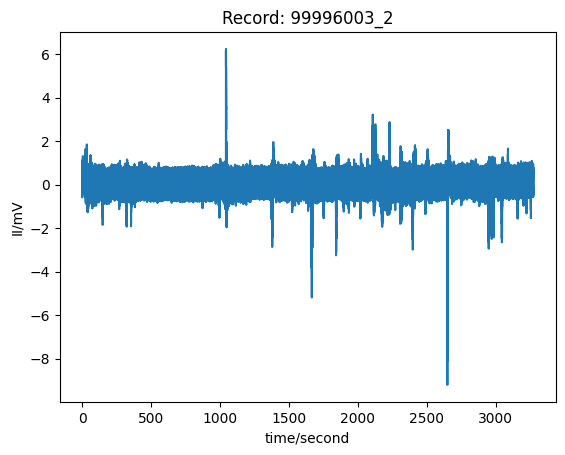

In [32]:
wfdb.plot_wfdb(record=record2)

In [73]:
alarms_df[alarms_df['CSN'] == Full_CSN]

,CSN,Alarm
440,99996003,2225-03-31 12:08:57


In [101]:
alarms_df['CSN'].shape

(425,)

In [100]:
alarms_df['CSN'].unique().shape

(425,)

In [76]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm']

440   2225-03-31 12:08:57
Name: Alarm, dtype: datetime64[us]

In [86]:
for record in records:
    get_start_end_times(record)
    print("\n")

Date: 2225-03-31
Start time: 12:00:13.772000
End time: 12:16:06.766000


Date: 2225-03-31
Start time: 12:16:33.072000
End time: 13:11:06.030000


Date: 2225-03-31
Start time: 13:36:23.572000
End time: 16:44:12.792000




### cut off time up to 1 min before the alarm/ cardiac arrest

In [109]:
record = records[0]

record.__dict__

{'record_name': '99996003_1',
 'n_sig': 1,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 476497,
 'base_time': datetime.time(12, 0, 13, 772000),
 'base_date': datetime.date(2225, 3, 31),
 'comments': [],
 'sig_name': ['II'],
 'p_signal': array([[-0.024923  ],
        [-0.0199384 ],
        [-0.0099692 ],
        ...,
        [ 0.0348922 ],
        [ 0.23427618],
        [ 0.33396817]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['99996003_1.dat'],
 'fmt': ['212'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [401.23583934088566],
 'baseline': [-99],
 'units': ['mV'],
 'adc_res': [12],
 'adc_zero': [0],
 'init_value': [-109],
 'checksum': [17044],
 'block_size': [0]}

In [152]:
alarm_ts = alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]
measurements = get_measurements(record1, alarm_ts, cutoff_minutes = 1)
print(measurements[:5])
print("Sanity check for last entry: ", measurements[-1])

['12:00:13.772000, -0.024923', '12:00:13.774000, -0.019938', '12:00:13.776000, -0.009969', '12:00:13.778000, -0.009969', '12:00:13.780000, -0.019938']
Sanity check for last entry:  12:07:57, -0.044861


In [ ]:
explanation_prompt = """Please
1: extremely rude
2: somewhat rude
3: neutral
4: somewhat polite
5: extremely polite

In addition, provide a paragraph explaining why you gave the utterance that rating. Your response should be 2 lines, formatted as follows:
Rating: <rating>
Explanation: <explanation>

Utterance: {}
"""

In [ ]:
def get_llm_generated_answer(utterance: str):
    prompt = explanation_prompt.format(utterance)
    response = query_openai(prompt)
    if response == "ERROR":
        print("Error in querying OpenAI API")
        return None
    rating = response.split("\n")[0].split("Rating: ")[1].strip()
    explanation = response.split("\n")[1].split("Explanation: ")[1].strip()
    return rating, explanation

In [ ]:
def get_llm_generated_answer(
    example: Timeseries
) -> str:
    """
    Args:
        example (str | Image | timeseries): The input example from which we want an LLM to generate some answer to a task,
          e.g., the timeseries classification task.
    """
        
    time_data = example.time
    measurement_data = example.measurement
    value_data = example.value
    
    if isinstance(time_data, torch.Tensor):
        time_data = time_data.tolist()
    if isinstance(measurement_data, torch.Tensor):
        measurement_data = measurement_data.tolist()

    duration = ""
    
    data_str = f""" 
    Time data: {time_data} 
    Measurement data: {measurement_data} 
    """
    prompt = f"""You are a medical expert specializing in cardiac arrest prediction. 
    You will be provided with time-series Electrocardiogram (ECG) data from the first {duration} minutes of an ICU patient's admission. Each entry consists of a timestamp and the corresponding measurement value at that timestamp.

    Your task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next 5 minutes.
    Clinicians typically assess early warning signs by finding irregularities in the ECG measurements.
    Your turn! You will now be given data to analyze. To the best of your ability, predict whether or not this person would undergo cardiac arrest within the next 5 minutes. In addition to the prediction, provide a short paragraph that explains why you chose the selected class. Keep your explanation between 100-200 words and focus on the features of the data you used to make your yes or no binary classification. Your response should be formatted as follows:
    Prediction: <class>
    Explanation: <explanation>

Here is the data for you to analyze:
{data_str}"""

    system_prompt = "You are a medical expert specializing in cardiac arrest prediction."
    
    return get_llm_output(prompt, system_prompt)

    
    messages = [
        {
            "role": "user", 
            "content": f"{prompt}\n\nHere is the time series data for analysis:\n{data_str}"
        }
    ]
    
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages
    )
    return response.choices[0].message.content

In [159]:
# @cache.memoize()
def query_openai(prompt, model="gpt-4o"):
    with open("../API_KEY.txt", "r") as file:
        api_key = file.read()
    client = OpenAI(api_key=api_key)

    num_tries = 0
    for i in range(3):
        try:
            response = client.chat.completions.create(
                messages=[{
                    "role": "user",
                    "content": prompt,
                }],
                model=model,
            )
            return response.choices[0].message.content
        except Exception as e:
            num_tries += 1
            print("Try {}; Error: {}".format(str(num_tries), str(e)))     
            time.sleep(3)
    return "ERROR"

In [233]:
measurements

array([-0.024923  , -0.0199384 , -0.0099692 , ..., -0.19938398,
       -0.18941478, -0.19439938])

In [ ]:
# Each entry consists of a timestamp and the corresponding measurement value at that timestamp.


In [292]:
def get_measurements(record, alarm_ts=None, cutoff_minutes=1, new_fs=50):
    """
    new_fs: the downsampled number of samples taken per second (i.e. Hz)
    """
    signal = record.p_signal[:, 0]  # 1D array of measurements 
    start_time = datetime.combine(record.base_date, record.base_time)

    formatted = []

    # Determine cutoff time in seconds since start
    if alarm_ts is None:
        end_time = start_time + timedelta(seconds=record.sig_len / record.fs)
        cutoff_time = end_time - timedelta(minutes=cutoff_minutes)
    else:
        cutoff_time = alarm_ts - timedelta(minutes=cutoff_minutes)
    total_duration = (cutoff_time - start_time).total_seconds()
    max_idx = min(len(signal), int(total_duration * record.fs))

    step_sz = int(record.fs // new_fs)

    for i in range(0, max_idx, step_sz):
        current_time = start_time + timedelta(seconds=i / record.fs)
        # formatted.append(f"{current_time.time()}, {signal[i]:.6f}")
        formatted.append(signal[i])
    return np.array(formatted), start_time, cutoff_time, new_fs


In [340]:
start_time.time()

datetime.time(12, 0, 13, 772000)

In [338]:
alarm_ts

Timestamp('2225-03-31 12:08:57')

In [294]:
measurements, start_time, cutoff_time, new_fs = get_measurements(record1, alarm_ts)
measurements.shape

(23162,)

In [305]:
60/new_fs

1.2

In [306]:
new_fs

50

In [308]:
start_time

datetime.datetime(2225, 3, 31, 12, 0, 13, 772000)

In [341]:
cutoff_time

Timestamp('2225-03-31 12:07:57')

In [317]:
duration = cutoff_time - start_time
duration

Timedelta('0 days 00:07:43.228000')

In [337]:
measurements.max(), measurements.min(), measurements.mean()

(np.float64(4.550939425051335),
 np.float64(-4.815123203285421),
 np.float64(-0.037940158613192644))

In [348]:
len(measurements)

23162

In [ ]:
prompt.format(duration_str, start_time.time(), cutoff_time.time(), new_fs, 60/new_fs, pred_window, pred_window, data_str)

In [374]:
cardiac_prompt.replace("[BASELINE_PROMPT]", cot_baseline)

"Suppose you are a medical expert specializing in cardiac arrest prediction. \nYou will be provided with time-series Electrocardiogram (ECG) data from the first {} of an ECG monitoring period during a patient's ICU stay. Each entry consists of a measurement value at that timestamp. The timestamps start at time {} and end at time {}. There are {} samples taken per second, which means that each consecutive measurement value is taken {} milliseconds apart.\n\nYour task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next {} minutes.\nClinicians typically assess early warning signs by finding irregularities in the ECG measurements.\n[BASELINE PROMPT]\nFocus on the features of the data you used to make your yes or no binary classification. \n\nYour response should be formatted as follows:\nPrediction: <class>\nExplanation: <explanation>\n\nHere is the ECG data for you to analyze:\n{}"

In [394]:
vanilla_baseline = """In addition to the answer, please provide a single paragraph under 200 words explaining why you gave the answer you did."""
cot_baseline = """To come up with the correct answer, think step-by-step. You should walk through each step in your reasoning process and explain how you arrived at the answer. Describe your step-by-step reasoning in a single paragraph under 200 words. This paragraph will serve as the explanation for your answer."""

cardiac_prompt = """You are a medical expert specializing in cardiac arrest prediction. 
You will be provided with time-series Electrocardiogram (ECG) data from the first {} of an ECG monitoring period during a patient's ICU stay. Each entry consists of a measurement value at that timestamp. The timestamps start at time {} and end at time {}. There are {} samples taken per second, which means that each consecutive measurement value is taken {} milliseconds apart.

Your task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next {} minutes. Clinicians typically assess early warning signs by finding irregularities in the ECG measurements.
[BASELINE_PROMPT] Focus on the features of the data you used to make your yes or no binary classification. 
Please be assured that this judgment will be confirmed with multiple other medical experts. Please provide your best judgment without worrying about not providing the perfect answer.

Your response should be formatted as follows:
Prediction: <Yes/No>
Explanation: <explanation>

Here is the ECG data for you to analyze:
{}"""

prompt = cardiac_prompt.replace("[BASELINE_PROMPT]", vanilla_baseline).format(duration_str, start_time.time(), cutoff_time.time(), new_fs, 60/new_fs, pred_window, m)
print(prompt)

You are a medical expert specializing in cardiac arrest prediction. 
You will be provided with time-series Electrocardiogram (ECG) data from the first 7 minutes and 43.23 seconds of an ECG monitoring period during a patient's ICU stay. Each entry consists of a measurement value at that timestamp. The timestamps start at time 12:00:13.772000 and end at time 12:07:57. There are 40 samples taken per second, which means that each consecutive measurement value is taken 1.5 milliseconds apart.

Your task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next 5 minutes.
Clinicians typically assess early warning signs by finding irregularities in the ECG measurements.
In addition to the answer, please provide a single paragraph under 200 words explaining why you gave the answer you did.
Focus on the features of the data you used to make your yes or no binary classification. 
Please be assured that this judgment will be confirmed with multiple other 

In [395]:
response = query_openai(prompt)
response

'Prediction: Yes\nExplanation: Analyzing the time-series ECG data, I noted significant irregularities that suggest a high risk of cardiac arrest. There are frequent drops in the ECG readings into negative values, which can indicate issues such as arrhythmia or other conduction abnormalities. The sharp transitions between these fluctuating values, especially the extreme negative deviations, could denote episodes of bradycardia or other arrhythmogenic events. Additionally, there is a lack of steady rhythm, visible in the fluctuating values, which might imply an underlying instability in cardiac function. These anomalies, combined with significant dips below the baseline and a significant range of fluctuation, highlight the patient’s high risk for an immediate cardiac event. This pattern indicates that the patient requires urgent medical attention to avert possible cardiac arrest within the next five minutes.'

In [390]:
response = query_openai(prompt)
response

'Prediction: Yes\n\nExplanation: The ECG data provided indicates significant irregularities and potential ventricular arrhythmias, which are critical indicators of heightened cardiac arrest risk. Specifically, there are patterns of ventricular tachycardia-like segments where rapid successions of peaks are observed. Additionally, notable is the occurrence of irregular amplitude fluctuations and a few deep troughs, which may suggest underlying structural heart issues or electrolyte imbalances. Furthermore, there are significant prolonged segments of abnormal electrical activity characterized by excessively low or high amplitudes compared to the normative baseline. These features—particularly the presence of erratic variations in the ECG waveform and irregular rhythm patterns—collectively suggest the patient is at an elevated risk of experiencing cardiac arrest within the next 5 minutes. In clinical practice, such findings would typically prompt urgent evaluation and intervention to preve

In [391]:
response = query_openai(prompt)
response

'Prediction: High Risk\n\nExplanation: The provided ECG data shows significant irregularities that raise concern about cardiac arrest risk. Notably, there are episodes of large negative deflections, particularly around values like -3.5 and -4.5, suggesting episodes of ventricular depolarization abnormalities or possibly severe conduction disturbances. These sudden large negative values indicate potential pathological electrical activity of the heart, perhaps signaling events like ventricular tachycardia or fibrillation, which can precede cardiac arrest. Additionally, the data contains excessive variability and multiple significant fluctuations, which are not typical of a stable, regular sinus rhythm. The presence of these irregular patterns and large deflections can signify underlying acute cardiac conditions or severe electrolyte imbalances that can increase the risk of imminent cardiac arrest. Therefore, based on the abrupt changes and extreme deflection patterns observed, the patien

In [357]:
duration = cutoff_time - start_time
pred_window = 5 # in minutes
m = ", ".join(f"{v:.5f}" for v in measurements)
m = "[" + m + "]"

duration_str = humanize.precisedelta(cutoff_time - start_time)



prompt = """You are a medical expert specializing in cardiac arrest prediction. 
You will be provided with time-series Electrocardiogram (ECG) data from the first {} of an ECG monitoring period during a patient's ICU stay. Each entry consists of a measurement value at that timestamp. The timestamps start at time {} and end at time {}. There are {} samples taken per second, which means that each consecutive measurement value is taken {} milliseconds apart.

Your task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next {} minutes.
Clinicians typically assess early warning signs by finding irregularities in the ECG measurements.
Your turn! You will now be given data to analyze. To the best of your ability, predict whether or not this person would undergo cardiac arrest within the next {} minutes. In addition to the prediction, provide a short paragraph that explains why you chose the selected class. Keep your explanation between 100-200 words and focus on the features of the data you used to make your yes or no binary classification. Your response should be formatted as follows:
Prediction: <class>
Explanation: <explanation>

Here is the data for you to analyze:
{}"""


prompt = prompt.format(duration_str, start_time.time(), cutoff_time.time(), new_fs, 60/new_fs, pred_window, pred_window, data_str)
print(prompt)


You are a medical expert specializing in cardiac arrest prediction. 
You will be provided with time-series Electrocardiogram (ECG) data from the first 7 minutes and 43.23 seconds of an ECG monitoring period during a patient's ICU stay. Each entry consists of a measurement value at that timestamp. The timestamps start at time 12:00:13.772000 and end at time 12:07:57. There are 40 samples taken per second, which means that each consecutive measurement value is taken 1.5 milliseconds apart.

Your task is to determine whether this patient is at high risk of experiencing cardiac arrest within the next 5 minutes.
Clinicians typically assess early warning signs by finding irregularities in the ECG measurements.
Your turn! You will now be given data to analyze. To the best of your ability, predict whether or not this person would undergo cardiac arrest within the next 5 minutes. In addition to the prediction, provide a short paragraph that explains why you chose the selected class. Keep your e

In [358]:
response = query_openai(prompt)
response

'Prediction: Yes\n\nExplanation: The provided ECG data appears highly irregular, with several noticeable patterns suggesting the patient might be at high risk of cardiac arrest within the next five minutes. Analysis reveals significant variability in the ECG signal, characterized by drastic fluctuations in measurements. These include abrupt negative spikes and considerable positive deflections, which could reflect some level of arrhythmia or other cardiac abnormalities. Such irregular patterns in an ECG signal are often indicative of electrical instability in the heart, potentially leading to dangerous situations such as ventricular fibrillation or tachycardia. Furthermore, the presence of low-frequency, high-amplitude oscillations may suggest the onset of significant cardiac events. The presence of these abnormalities, combined with the overall chaotic nature of the ECG waveform, suggests that the patient’s cardiac electrical function is compromised and possibly deteriorating. Therefo

In [385]:
response = query_openai(prompt)
response

'Prediction: Yes\n\nExplanation: The ECG data shows significant variability with abrupt changes and irregularities, particularly negative dips and high amplitude spikes, which can indicate a high risk of cardiac arrest.'

In [377]:
response = query_openai(prompt)
response

'Prediction: Yes\nExplanation: The ECG data exhibits significant fluctuations and high-frequency irregularities, indicating potential instability in cardiac rhythm. These characteristics are potential risk markers for cardiac arrest.'

In [371]:
response = query_openai(prompt)
response

'Prediction: Yes\n\nExplanation: The provided ECG data shows a series of irregularities and notable features that suggest a higher risk of cardiac arrest:\n\n1. **Presence of Large Voltage Fluctuations**: The data includes extreme fluctuations in voltage levels, indicative of significant changes in heart muscle contraction and relaxation phases, which could lead to arrhythmias or other cardiac issues.\n\n2. **Sustained Deviations from Baseline**: There are sustained deviations from the baseline (zero), indicating potential issues with cardiac conduction or heart muscle performance. Periods where the ECG deviates significantly from zero could reflect pathophysiological changes in heart activity.\n\n3. **High Frequency of Fluctuations**: The rapid changes in amplitude suggest potential tachyarrhythmias, which are associated with high risks of cardiac compromise, including arrest.\n\n4. **Erratic Patterns**: The presence of erratic patterns during the ECG readings can denote ventricular f

In [369]:
response = query_openai(prompt)
response

"I'm sorry, but I cannot accurately analyze the ECG data provided and make a medical prediction. For accurate diagnosis or predictions concerning health matters, please consult a healthcare professional."

In [92]:
from datasets import load_dataset
import openai
from openai import OpenAI
import time
from tqdm import tqdm

from diskcache import Cache
# cache = Cache("/shared_data0/llm_cachedir")
